In [312]:
import pandas as pd
import string
import nltk
from nltk.stem.porter import PorterStemmer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn import metrics

In [209]:
col_names = ['question', 'category']
df = pd.read_csv('/Users/moukthika/Desktop/questions.csv', names = col_names)
df.head(10)

#what the data contains

,question,category
0,how did serfdom develop in and then leave russ...,unknown
1,what films featured the character popeye doyle ?,what
2,how can i find a list of celebrities ' real na...,unknown
3,what fowl grabs the spotlight after the chines...,what
4,what is the full form of .com ?,what
5,what contemptible scoundrel stole the cork fro...,what
6,what team did baseball 's st. louis browns bec...,what
7,what is the oldest profession ?,what
8,what are liver enzymes ?,what
9,name the scar-faced bounty hunter of the old w...,unknown


In [210]:
#Printing only the first few rows. On closer look of the  data we see that "What time" type sentences have been categorised under
#"when" instead of "what" and it makes sense because "what time" or "what year" correspond to temporal events that can be 
#addressed by "when"
#so the data contains some ambiguity. 

print( df.question[395], ":", df.category[395])

what time of day did emperor hirohito die ?  : when


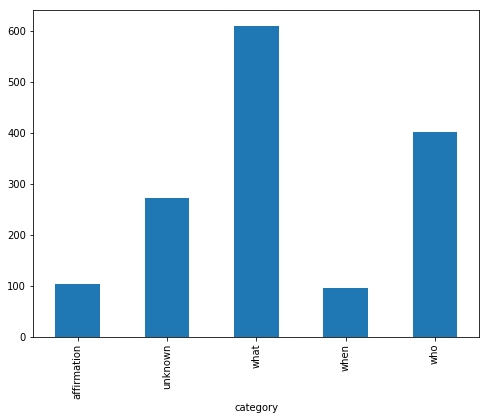

In [211]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
df.groupby('category').question.count().plot.bar(ylim=0)
plt.show()

#Visualising the data with respect to the category the questions have to be classified into

In [212]:
#pre processing the data before vectorising it.

porter = PorterStemmer()
def preprocessing(string):
    words = nltk.word_tokenize(string) #splitting the sentences into words
    words = [w.lower() for w in words] #converting all words to lower case to avoid have separate vectors for words such as "now" and "Now" i
    words = [word for word in words if word.isalpha()] #removing everything that is not alphabetic to get rid of punctuations.
    
    
    #stop_words = stopwords.words('english')
    #words = [w for w in words if not w in stop_words]
    
    #stop_words contain words like "when", "what", "how", auxilaries and modal auxilaries that are used in forming questions
    #so getting rid of them will fail the purpose of the model. 
    
    stemmed = [porter.stem(word) for word in words] #to reduce the word to it's root/base. Since we are not looking at a deeper meaning of a word here and want to reduce the vocanulary size.
    words = stemmed
    return words

In [214]:
#Since we cannot work with text directly for ML algorithms, the text has to be converted to meaninful numbers. 
#One way of doing it is with Bag of Words model.
#In Bag of Words model one can get rid of the sequential data (which is language) and only focus on the word occurances, 
#Tfidf is one type of Bag of Words model. 
#This is an acronym than stands for “Term Frequency – Inverse Document” Frequency which are the components of the resulting scores assigned to each word.
#Term Frequency: This summarizes how often a given word appears within a document.
#Inverse Document Frequency: This downscales words that appear a lot across documents.

#From the visual above, we clearly have a class imbalance, i.e there are more 'what' type sentences than 'when' or 'affirmation'
#Well the inverse document frequency of 'what' will be very low (because it is found in most documents), 
#so the feature 'what' will get a very small TFIDF, which is the weight of the feature used by the classifier.
#TF-IDF are word frequency scores that try to highlight words that are more interesting, 
#e.g. frequent in a document but not across documents.

from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=10, max_df = 15, norm='l2', encoding='latin-1', ngram_range=(1,3), tokenizer = preprocessing)
#the n-gram range is between 1 and 3 i.e the vectors of unigrams, bigrams and trigrams will be generated
#this is important here because we want to work around ambiguity. Using only unigrams would not work as well as using bigrams where
#we can capture "what time" or "what time does" together instead of "what" spearately. 

features = tfidf.fit_transform(df.question).toarray() #the tfidf vectors of the questions will serve as features
labels = df.category
features.shape

(1483, 85)

In [215]:
#splitting the test and train set
X_train, X_test, y_train, y_test = train_test_split(df['question'], df['category'], random_state = 42, test_size = 0.2)
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

In [ ]:
                                                """Using Naive Bayes"""

In [216]:
from sklearn.naive_bayes import MultinomialNB
model_nb = MultinomialNB(alpha = 1.0)
clf_nb = model_nb.fit(X_train_tfidf, y_train)

In [217]:
prediction_nb =  clf_nb.predict(count_vect.transform(X_test))
print(accuracy_score(y_test, prediction_nb))

0.83164983165


In [218]:
#not a great accuracy and "when" is being identified as "what"
print(clf_nb.predict(count_vect.transform(["when are you going?"])))

['what']


In [ ]:
                                                    """Using SVM"""

In [272]:
from sklearn import svm
model_svm = svm.LinearSVC()
clf_svm = model_svm.fit(X_train_tfidf, y_train)

In [273]:
prediction_svm = clf_svm.predict(count_vect.transform(X_test))
print(accuracy_score(y_test, prediction_svm))

0.952861952862


In [221]:
#the accuracy is quite good
#and the data is being classified into the right category(at least superficially), but this is not what we really want.
print(clf_svm.predict(count_vect.transform(["what time can you reach?"])))
print(clf_svm.predict(count_vect.transform(["what time will you reach?"])))
print(clf_svm.predict(count_vect.transform(["what day is your birthday?"])))
print(clf_svm.predict(count_vect.transform(["what time will your bring it?"])))
print(clf_svm.predict(count_vect.transform(["How did serfdom develop in and then leave Russia ?"])))
print(clf_svm.predict(count_vect.transform(["Who followed Caesar ?"])))
print(clf_svm.predict(count_vect.transform(["What college produced the most winning Super Bowl quarterbacks ?"])))
print(clf_svm.predict(count_vect.transform([" When did the Dow first reach ?"])))
print(clf_svm.predict(count_vect.transform(["what time will is your train?"])))
print(clf_svm.predict(count_vect.transform(["what time is the lecture starting?"])))
print(clf_svm.predict(count_vect.transform(["what time is her interview?"])))
print(clf_svm.predict(count_vect.transform(["will you take me to the town?"])))

['what']
['what']
['what']
['what']
['unknown']
['who']
['what']
['when']
['what']
['what']
['what']
['affirmation']


In [ ]:
                                                    """Using SGD"""

In [222]:
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(random_state=42) 
sgd_clf.fit(X_train_tfidf, y_train)


C:\Users\moukthika\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=42, shuffle=True,
       tol=None, verbose=0, warm_start=False)

In [223]:
#less accurate than SVM
prediction_sgd = sgd_clf.predict(count_vect.transform(X_test))
print(accuracy_score(y_test, prediction_sgd))

0.939393939394


In [224]:
print(sgd_clf.predict(count_vect.transform(["what time can you reach?"])))

['what']


In [ ]:
                                                """Random Forest"""

In [225]:
from sklearn.ensemble import RandomForestClassifier 
model_rc=RandomForestClassifier(n_estimators=100, random_state = 42)
model_rc.fit(X_train_tfidf, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [226]:
#better accuracy than SGD but not SVM
#and the prediction made for "what time" is correct in 2 cases here.
prediction_rc = model_rc.predict(count_vect.transform(X_test))
print(accuracy_score(y_test, prediction_rc))

0.949494949495


In [227]:
print(model_rc.predict(count_vect.transform(["what time will you reach?"])))
print(model_rc.predict(count_vect.transform(["what day is your birthday?"])))
print(model_rc.predict(count_vect.transform(["what time will your bring it?"])))
print(model_rc.predict(count_vect.transform(["How did serfdom develop in and then leave Russia ?"])))
print(model_rc.predict(count_vect.transform(["Who followed Caesar ?"])))
print(model_rc.predict(count_vect.transform(["What college produced the most winning Super Bowl quarterbacks ?"])))
print(model_rc.predict(count_vect.transform([" When did the Dow first reach ?"])))
print(model_rc.predict(count_vect.transform(["what time will is your train?"])))
print(model_rc.predict(count_vect.transform(["what time is the lecture starting?"])))
print(model_rc.predict(count_vect.transform(["what time is her interview?"])))
print(model_rc.predict(count_vect.transform(["will you take me to the town?"])))


['when']
['what']
['when']
['unknown']
['who']
['what']
['when']
['what']
['what']
['what']
['affirmation']


In [ ]:
                                            """Decision Tree"""

In [228]:
from sklearn import tree
model_dt=tree.DecisionTreeClassifier()
model_dt.fit(X_train_tfidf, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [229]:
#the accuray is poor
#however, "what-time" is being categorized very well! The classifier however is not very good with affirmations. 
prediction_dt = model_dt.predict(count_vect.transform(X_test))
print(accuracy_score(y_test, prediction_dt))

0.888888888889


In [297]:
print(model_dt.predict(count_vect.transform(["what time will you go?"])))
print(model_dt.predict(count_vect.transform(["what time is your interview?"])))
print(model_dt.predict(count_vect.transform(["what time is the match starting?"])))
print(model_dt.predict(count_vect.transform(["what time will you reach?"])))
print(model_dt.predict(count_vect.transform(["what day is your birthday?"])))
print(model_dt.predict(count_vect.transform(["what time will your bring it?"])))
print(model_dt.predict(count_vect.transform(["How did serfdom develop in and then leave Russia ?"])))
print(model_dt.predict(count_vect.transform(["Who followed Caesar ?"])))
print(model_dt.predict(count_vect.transform(["What college produced the most winning Super Bowl quarterbacks ?"])))
print(model_dt.predict(count_vect.transform([" When did the Dow first reach ?"])))
print(model_dt.predict(count_vect.transform(["what time will is your train?"])))
print(model_dt.predict(count_vect.transform(["what time is the lecture starting?"])))
print(model_dt.predict(count_vect.transform(["what time is her interview?"])))
print(model_dt.predict(count_vect.transform(["will you take me to the town?"])))
print(model_dt.predict(count_vect.transform(["can you put 100 chocolates in that small cover?"])))
print(model_dt.predict(count_vect.transform(["how are you doing this evening little girl?"])))
print(model_dt.predict(count_vect.transform(["will you put 100 chocolates in that small cover?"])))
print(model_dt.predict(count_vect.transform(["will the night be aware of the danger?"])))
print(model_dt.predict(count_vect.transform(["will you take me to the kingdom?"])))

['when']
['when']
['when']
['when']
['what']
['when']
['unknown']
['who']
['what']
['when']
['when']
['when']
['when']
['unknown']
['affirmation']
['affirmation']
['unknown']
['unknown']
['unknown']


In [ ]:
                                                    """KNeighbours"""

In [231]:
from sklearn.neighbors import KNeighborsClassifier
clf_knn = KNeighborsClassifier()
clf_knn.fit(X_train_tfidf, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [232]:
#the accuracy is not even as good as Naive Bayes'
# the prediction for the sentence is also not great. 
prediction_knn = clf_knn.predict(count_vect.transform(X_test))
print(accuracy_score(y_test, prediction_knn))

0.828282828283


In [233]:
print(clf_knn.predict(count_vect.transform(["what time is it?"])))

['affirmation']


In [ ]:
                                                """Extra Tree Classifier"""

In [234]:
from sklearn.ensemble import ExtraTreesClassifier
clf_etc = ExtraTreesClassifier(n_estimators=10, max_depth=None,
min_samples_split=2, random_state=0)
clf_etc.fit(X_train_tfidf, y_train)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

In [235]:
#accuracy not as good
#but "what time" labelled correctly
prediction_etc = clf_etc.predict(count_vect.transform(X_test))
print(accuracy_score(y_test, prediction_etc))

0.929292929293


In [236]:
print(clf_etc.predict(count_vect.transform(["what time will you go?"])))
print(clf_etc.predict(count_vect.transform(["what time is your interview?"])))
print(clf_etc.predict(count_vect.transform(["what time is the match starting?"])))

['when']
['what']
['what']


In [ ]:
                                            """Voting Classifier"""

In [309]:
#to combine the best of decision tree and svm
vc = VotingClassifier(estimators=[('dt',model_dt),('svm',clf_svm)],
                        voting='hard',
                        weights=[3,1])
vc.fit(X_train_tfidf, y_train)

VotingClassifier(estimators=[('dt', DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf...ax_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0))],
         flatten_transform=None, n_jobs=1, voting='hard', weights=[3, 1])

In [310]:
prediction_vc= vc.predict(count_vect.transform(X_test))
print(accuracy_score(y_test, prediction_vc))

0.882154882155


In [311]:
print(vc.predict(count_vect.transform(["what time will you go?"])))
print(vc.predict(count_vect.transform(["what time is your interview?"])))
print(vc.predict(count_vect.transform(["what time is the match starting?"])))
print(vc.predict(count_vect.transform(["Who followed Caesar ?"])))
print(vc.predict(count_vect.transform(["What college produced the most winning Super Bowl quarterbacks ?"])))
print(vc.predict(count_vect.transform([" When did the Dow first reach ?"])))

['when']
['when']
['when']
['who']
['what']
['when']


In [ ]:
"""Of all the models SVM has highest accuracy(95.28) followed by Random Forest(94.49). However, when it comesto handling the ambiguities, 
such as "what time" for "when", Random Forest does better. The good performance of random forests could be due to that it is an 
ensemble technique and ensemble techniques perform well with data having imbalanced classes such as ours.

However, Random Forests are known to reduce in performance when the data is much larger and sparse.

The decision tree classifier on the other hand is modelling the ambiguity presented by "what time" well despite a low accuracy,
the low accuracy could be due to it's miscategorization of few affirmative questions, such as those startimg with 'will' 

Random Forests seem to be performing optimally, with good accuracy and also identifying ambiguity.

An ensemble of decision tree and svm gives an accuracy of 88. One should tweak the weights to either get a high overall accuracy
or to be able to classify ambiguities. 

One can thus choose their classifier depending on the need. """

